# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score , f1_score

In [ ]:
#Function to plot the Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('importances-01.png')
    plt.show()
    sns.set()

# Read the Data


In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/mohammad2012191/Drafts/main/diabetes-dataset.csv")

# Statistics About the Data

In [ ]:
train_df.shape

(2000, 9)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [ ]:
train_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [ ]:
train_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


# Plots


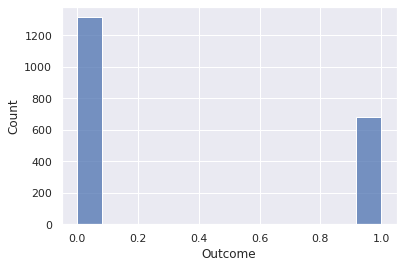

In [ ]:
#Target Histogram
sns.set()
sns.histplot(train_df['Outcome'])

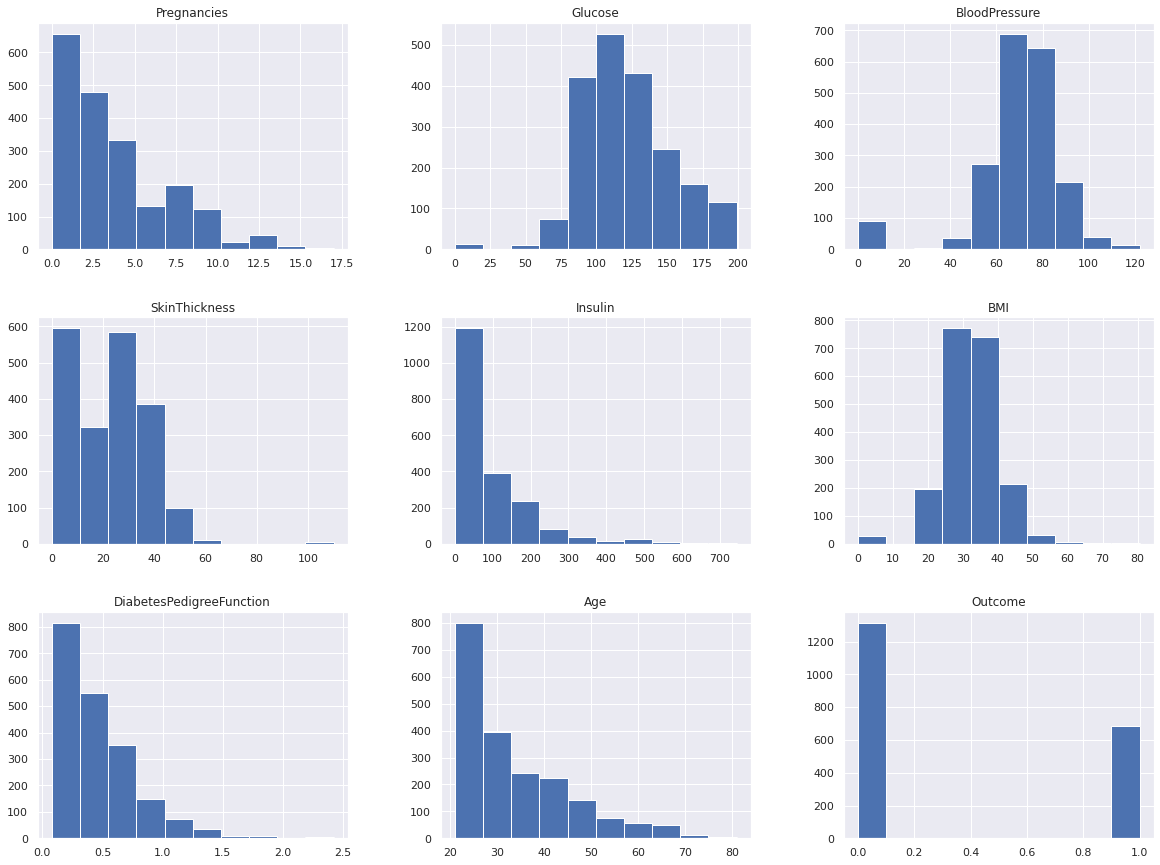

In [ ]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

# Data Preprocessing

## Missing Values Removal

In [ ]:
print('Number of Samples Before Removing Missing Values: ', train_df.shape[0])

train_df = train_df[train_df['BloodPressure'] != 0]
train_df = train_df[train_df['Glucose'] != 0]
train_df = train_df[train_df['BMI'] != 0]
train_df = train_df.reset_index(drop=True)

print('Number of Samples After Removing Missing Values: ', train_df.shape[0])

Number of Samples Before Removing Missing Values:  2000
Number of Samples After Removing Missing Values:  1888


## Normalizing the Data

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
            'BMI', 'DiabetesPedigreeFunction', 'Age']
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])

# Modeling

In [ ]:
lr_params = {'C':1, 'max_iter': 10000}
sv_params = {'C':50.0, 'kernel':'linear'}
rf_params = {'max_depth': 10, 'n_jobs': -1, 'n_estimators': 1000}
knn_params = {'n_neighbors': 3}

In [ ]:
lr = LogisticRegression(**lr_params, random_state=42)
sv = SVC(**sv_params, random_state=42)
rf = RandomForestClassifier(**rf_params, random_state=42)
knn = KNeighborsClassifier(**knn_params)

## Validation:

In [ ]:
#Save the predictions to calculate the metrics later
preds = pd.DataFrame(index=train_df.index)

## Logistic Regression

In [ ]:
X = train_df.drop('Outcome',axis=1)
y = train_df['Outcome']


scores = []
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=1).split(X,y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    lr.fit(X_train,y_train)
    y_preds = lr.predict(X_test)
    preds.loc[test_index,'LR'] = y_preds.copy()

    scores.append(accuracy_score(y_test,y_preds))
    print(scores[-1])

print(f'Mean Accuracy of Logistic Regression: {np.mean(scores)}')

0.716931216931217
0.7883597883597884
0.791005291005291
0.8196286472148541
0.76657824933687
Mean Accuracy of Logistic Regression: 0.776500638569604


## Support Vector Machine (SVM)

In [ ]:
X = train_df.drop('Outcome',axis=1)
y = train_df['Outcome']


scores = []
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=1).split(X,y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    sv.fit(X_train,y_train)
    y_preds = sv.predict(X_test)
    preds.loc[test_index,'SVM'] = y_preds.copy()

    scores.append(accuracy_score(y_test,y_preds))
    print(scores[-1])

print(f'Mean Accuracy of Support Vector Machine: {np.mean(scores)}')

0.708994708994709
0.7883597883597884
0.783068783068783
0.8196286472148541
0.753315649867374
Mean Accuracy of Support Vector Machine: 0.7706735155011015


## Random Forest

In [ ]:
X = train_df.drop('Outcome',axis=1)
y = train_df['Outcome']


scores = []
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=1).split(X,y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    rf.fit(X_train,y_train)
    y_preds = rf.predict(X_test)
    preds.loc[test_index,'RF'] = y_preds.copy()

    scores.append(accuracy_score(y_test,y_preds))
    print(scores[-1])

print(f'Mean Accuracy of Random Forest: {np.mean(scores)}')

0.9444444444444444
0.9761904761904762
0.9788359788359788
0.9655172413793104
0.9655172413793104
Mean Accuracy of Random Forest: 0.9661010764459041


## KNN

In [ ]:
X = train_df.drop('Outcome',axis=1)
y = train_df['Outcome']


scores = []
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=1).split(X,y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    knn.fit(X_train,y_train)
    y_preds = knn.predict(X_test)
    preds.loc[test_index,'KNN'] = y_preds.copy()

    scores.append(accuracy_score(y_test,y_preds))
    print(scores[-1])

print(f'Mean Accuracy of KNN: {np.mean(scores)}')

0.8650793650793651
0.8888888888888888
0.8756613756613757
0.8514588859416445
0.8806366047745358
Mean Accuracy of KNN: 0.8723450240691619


## Show the Features Importances 

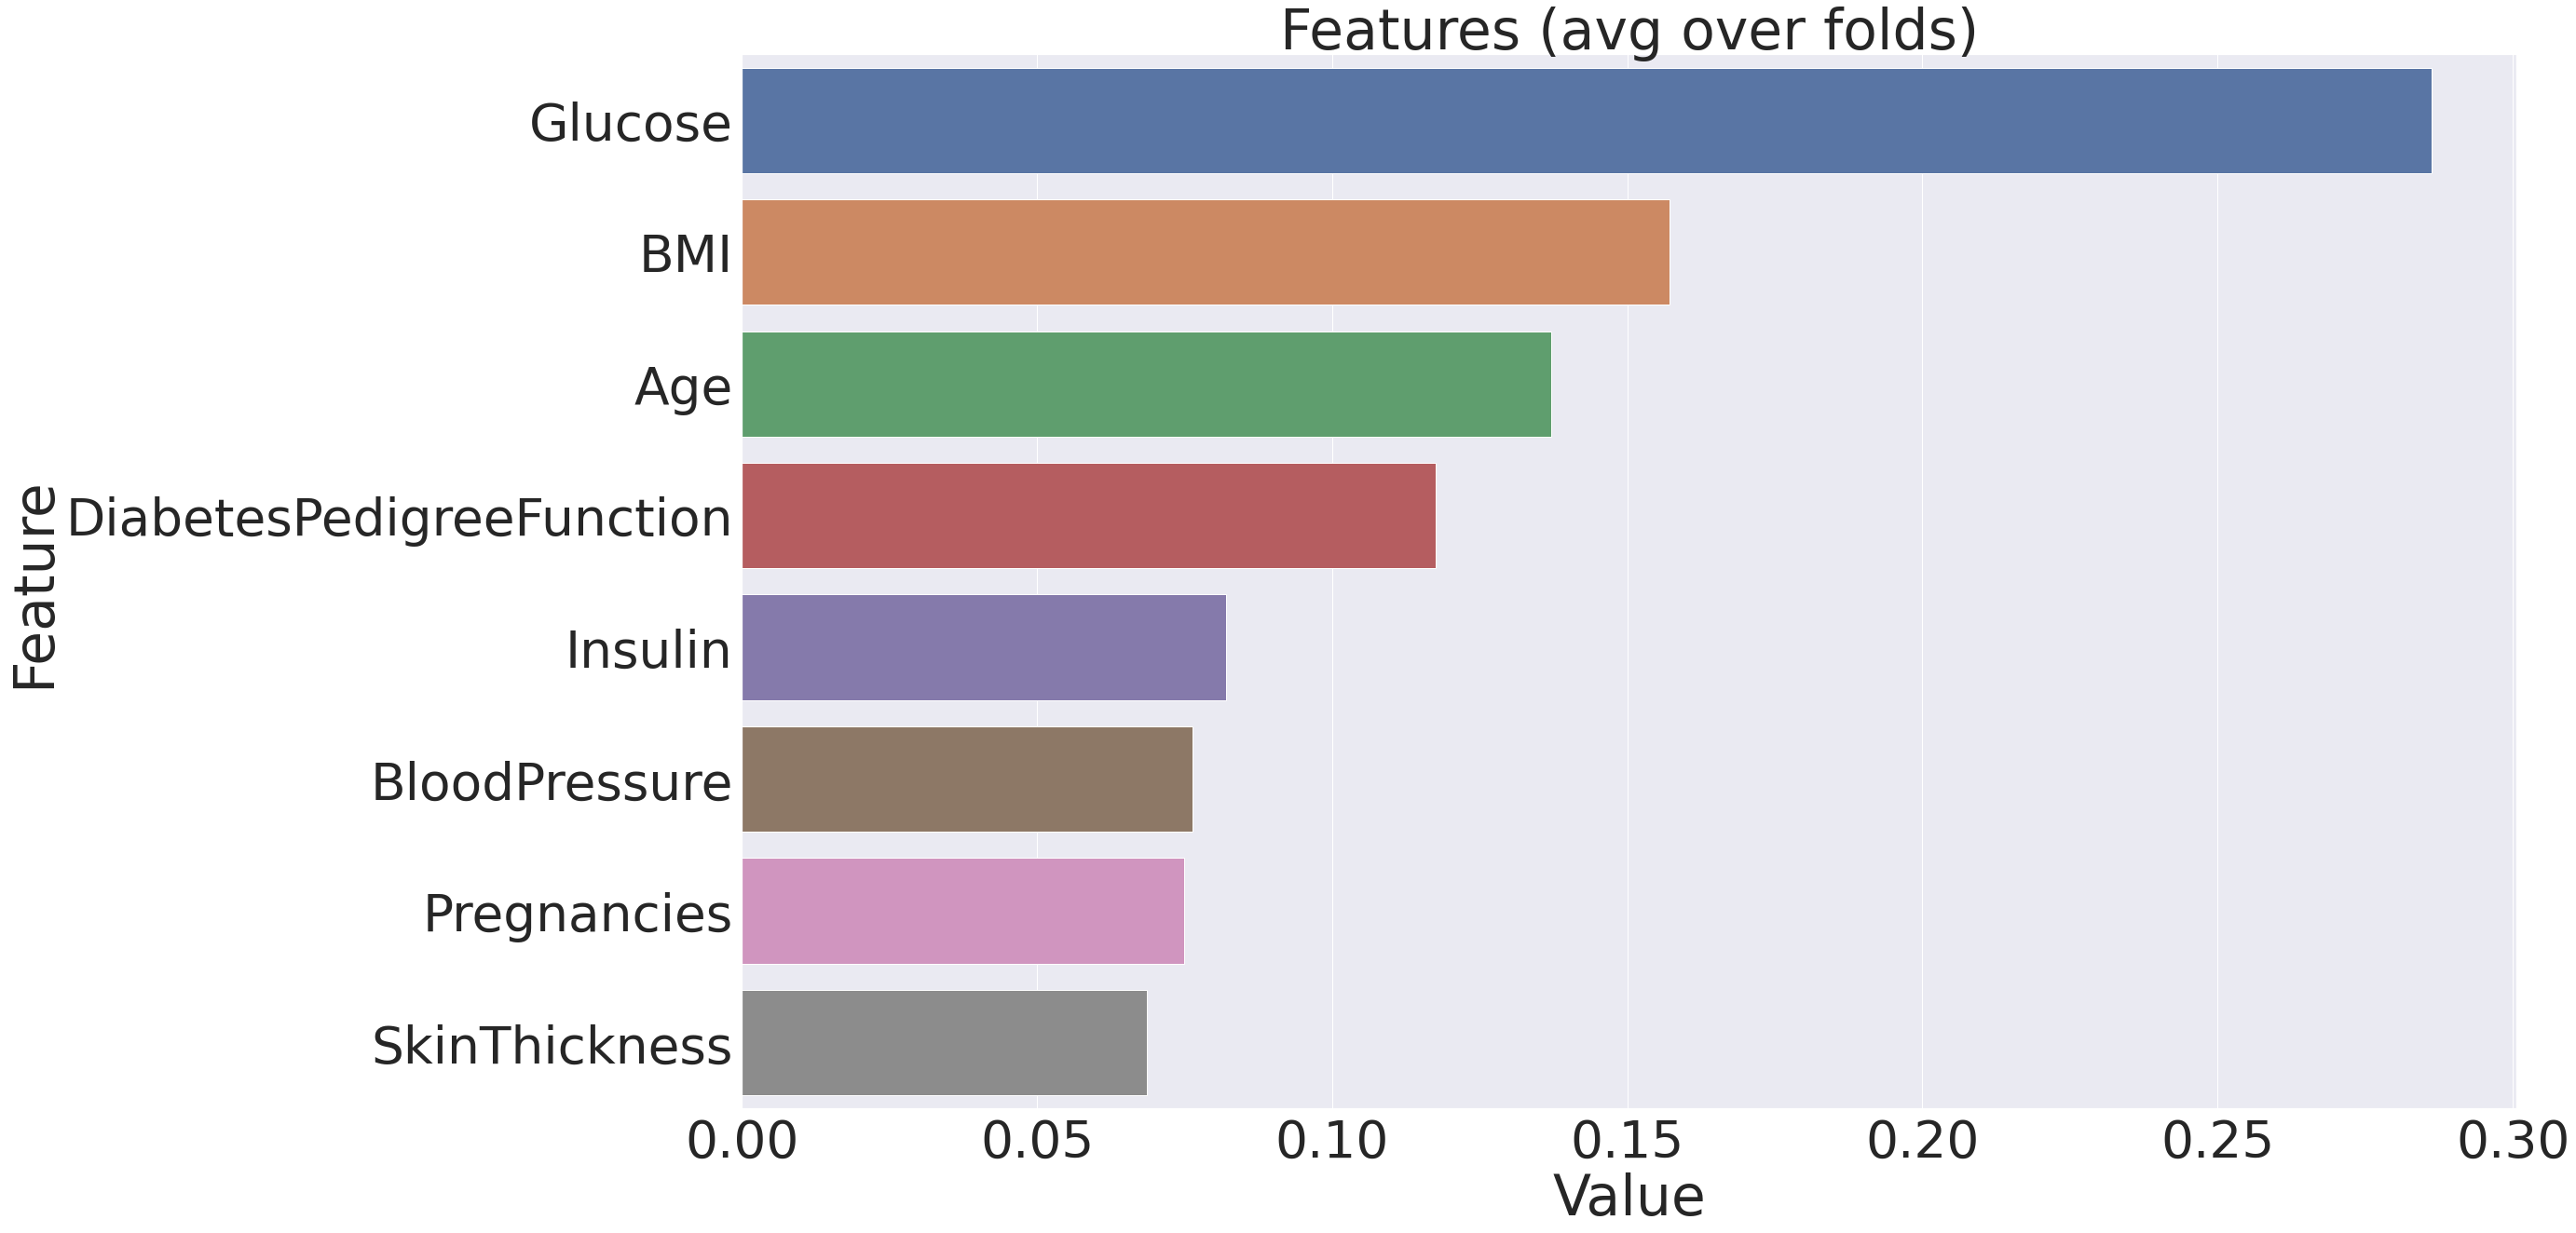

In [ ]:
plotImp(rf,train_df.drop('Outcome',axis=1))

# Evaluating the Full predictions of the models

In [ ]:
#Metrics for Logistic Regression
print('Logistic Regression')
print("Accuracy: ",accuracy_score(y, preds['LR']))
print("Precision: ",precision_score(y, preds['LR']))
print("Recall: ",recall_score(y, preds['LR']))
print("F1 Score: ",f1_score(y, preds['LR']))

Logistic Regression
Accuracy:  0.7764830508474576
Precision:  0.721881390593047
Recall:  0.5524256651017214
F1 Score:  0.625886524822695


In [ ]:
#Metrics for SVM
print('SVM')
print("Accuracy: ",accuracy_score(y, preds['SVM']))
print("Precision: ",precision_score(y, preds['SVM']))
print("Recall: ",recall_score(y, preds['SVM']))
print("F1 Score: ",f1_score(y, preds['SVM']))

SVM
Accuracy:  0.770656779661017
Precision:  0.706
Recall:  0.5524256651017214
F1 Score:  0.6198419666374012


In [ ]:
#Metrics for Random Forest
print('Random Forest')
print("Accuracy: ",accuracy_score(y, preds['RF']))
print("Precision: ",precision_score(y, preds['RF']))
print("Recall: ",recall_score(y, preds['RF']))
print("F1 Score: ",f1_score(y, preds['RF']))

Random Forest
Accuracy:  0.9661016949152542
Precision:  0.9570747217806042
Recall:  0.9420970266040689
F1 Score:  0.9495268138801262


In [ ]:
#Metrics for KNN
print('KNN')
print("Accuracy: ",accuracy_score(y, preds['KNN']))
print("Precision: ",precision_score(y, preds['KNN']))
print("Recall: ",recall_score(y, preds['KNN']))
print("F1 Score: ",f1_score(y, preds['KNN']))

KNN
Accuracy:  0.8723516949152542
Precision:  0.8042813455657493
Recall:  0.8231611893583725
F1 Score:  0.8136117556071153


# Comparison Between the Metrics and Predictions

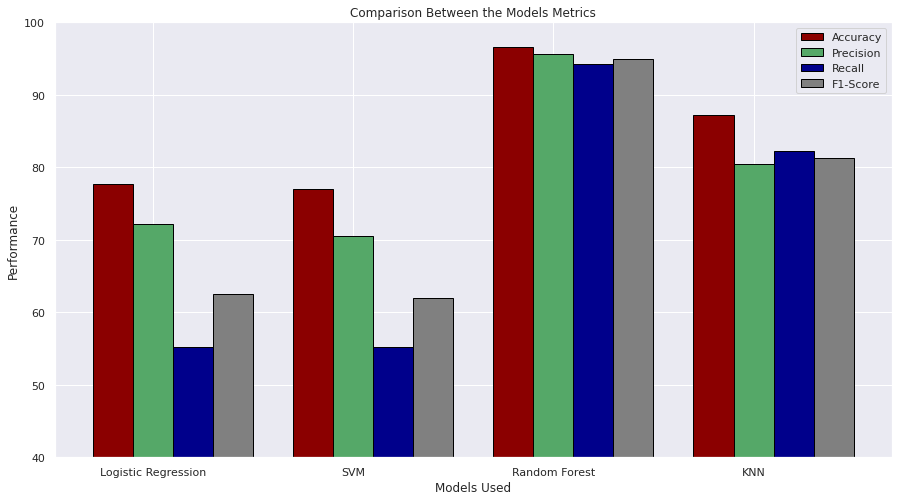

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
# creating the dataset
metric_1 = {'Logistic Regression':accuracy_score(y, preds['LR'])*100,
            'SVM':accuracy_score(y, preds['SVM'])*100,
            'Random Forest':accuracy_score(y, preds['RF'])*100, 
            'KNN':accuracy_score(y, preds['KNN'])*100}
metric_2 = {'Logistic Regression':precision_score(y, preds['LR'])*100,
            'SVM':precision_score(y, preds['SVM'])*100,
            'Random Forest':precision_score(y, preds['RF'])*100, 
            'KNN':precision_score(y, preds['KNN'])*100}
metric_3 = {'Logistic Regression':recall_score(y, preds['LR'])*100,
            'SVM':recall_score(y, preds['SVM'])*100,
            'Random Forest':recall_score(y, preds['RF'])*100, 
            'KNN':recall_score(y, preds['KNN'])*100}
metric_4 = {'Logistic Regression':f1_score(y, preds['LR'])*100,
            'SVM':f1_score(y, preds['SVM'])*100,
            'Random Forest':f1_score(y, preds['RF'])*100, 
            'KNN':f1_score(y, preds['KNN'])*100}
#Values of Metrics   
auc = list(metric_1.values())
precision = list(metric_2.values())
recall = list(metric_3.values())
f1_score = list(metric_4.values())
  
#Define the plot
fig = plt.subplots(figsize =(15, 8))
 
#Define the Distances
br1 = np.arange(4)
br2 = [x + 0.20 for x in br1]
br3 = [x + 0.20 for x in br2]
br4 = [x + 0.20 for x in br3]


#Create the bar plot
plt.bar(br1, auc, color ='darkred', width = 0.20,
        edgecolor ='black', label ='Accuracy')
plt.bar(br2, precision, color ='g', width = 0.20,
        edgecolor ='black', label ='Precision')
plt.bar(br3, recall, color ='darkblue', width = 0.20,
        edgecolor ='black', label ='Recall')
plt.bar(br4, f1_score, color ='gray', width = 0.20,
        edgecolor ='black', label ='F1-Score')

#Name the of The x-axis
plt.xticks([r + 0.20 for r in range(4)],
        ['Logistic Regression', 'SVM', 'Random Forest', 'KNN'])

#y-axis Boundaries
plt.ylim((40,100))

plt.xlabel("Models Used")
plt.ylabel("Performance")
plt.title("Comparison Between the Models Metrics")
plt.legend()
plt.show()